# M-Estimation for multiple biases
In this tutorial, we will demonstrate how the M-Estimation framework can easily be used to address multiple biases. In this particular example, we will address confounding, missing data, and generalizability. To showcase how estimating equations can be stacked together, these biases will be addressed iteratively. 

In [1]:
# Initial setup
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_logistic_regression 
from delicatessen.estimating_equations import ee_ridge_linear_regression
from delicatessen.utilities import inverse_logit

np.random.seed(51520837)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Delicatessen version:", delicatessen.__version__)

NumPy version:        1.19.5
SciPy version:        1.5.4
Pandas version:       1.1.5
Delicatessen version: 0.1


## Motivating Problem
We are interested in estimating the average causal effect of action $A$ on the outcome $Y$. We can express this parameter as 
$$E[Y^{a=1}] - E[Y^{a=0}]$$
where $Y^a$ is the potential outcome under action $a$. To estimate this quantity, we will need some assumptions and some data. To express how the data is generated, I will create a DAG using `zEpid`.

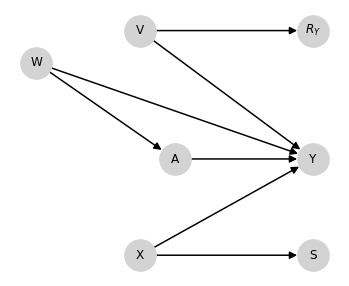

In [2]:
from zepid.causal.causalgraph import DirectedAcyclicGraph
from zepid.graphics import pvalue_plot

dag = DirectedAcyclicGraph(exposure="A", outcome="Y")
dag.add_arrows(pairs=(("A", "Y"), 
                      ("W", "Y"), ("W", "A"),
                      ("V", r"$R_Y$"), ("V", "Y"),
                      ("X", "S"), ("X", "Y")))
pos = {"A": [0, 0], "Y": [1, 0], "W": [-1, 0.75],
       "V": [-0.25, 1], r"$R_Y$": [1, 1], 
       "X": [-0.25, -0.75], "S": [1, -0.75]}
dag.draw_dag(positions=pos)
plt.show()

where $W,V,X$ are baseline variables, $R_Y$ is an indicator for missingness of $Y$, and $S$ is selection into the sample (e.g., not a random sample of the target population). 

Therefore, there are 3 sources of biases we need to address: confounding of $A$ and $Y$ by $W$, informative missing by $V$, and differences in the distribution of $X$ between the analytic sample and the target population. Below is a data generating procedure consistent with the causal diagram

In [3]:
n = 100000  # Generating lots of observations to reduce randomness

# Generating baseline covariates
d = pd.DataFrame()
d['W'] = np.random.normal(size=n)
d['V'] = np.random.randint(0, 3, size=n)
d['X'] = np.random.randint(0, 4, size=n)

# Generating actions
pr_a = sp.stats.logistic.cdf(-0.8 + 0.7*d['W'])
d['A'] = np.random.binomial(n=1, p=pr_a,
                            size=n)

# Generating potential outcomes
d['Ya1'] = (25 + 2 - 0.95*d['W'] 
            + 0*(d['V']==1) + 1*(d['V']==2)
            + 2.5*(d['X']==1) + 1.5*(d['X']==2) + 1.5*(d['X']==3)
            - 3*1*(d['V']==1) + 1.5*1*(d['V']==2)            
            - 0.6*1*(d['X']==2) - 1.5*1*(d['X']==3)
            + np.random.normal(size=n))
d['Ya0'] = (25 + 0 - 0.95*d['W'] 
            + 0*(d['V']==1) + 1*(d['V']==2)
            + 2.5*(d['X']==1) + 1.5*(d['X']==2) + 1.5*(d['X']==3)
            - 3*0*(d['V']==1) + 1.5*0*(d['V']==2)            
            - 0.6*0*(d['X']==2) - 1.5*0*(d['X']==3)
            + np.random.normal(size=n))
# Generating outcomes via causal consistency
d['Y'] = np.where(d['A'] == 1, d['Ya1'], d['Ya0'])

# Generating informative missing
pr_r = sp.stats.logistic.cdf(3
                             + 4*(d['V']==1) 
                             - 3*(d['V']==2))
d['R'] = np.random.binomial(n=1, p=pr_r,
                            size=n)
d['Y'] = np.where(d['R'] == 1, d['Y'], np.nan)

# Generating selection into sample
pr_s = sp.stats.logistic.cdf(- 1*(d['X']==0)
                             + 2*(d['X']==1)
                             + 3*(d['X']==2) 
                             + 4*(d['X']==3))
d['S'] = np.random.binomial(n=1, p=pr_s,
                            size=n)
d['A'] = np.where(d['S'] == 1, d['A'], np.nan) # Hiding A,R,Y if not in S=1
d['R'] = np.where(d['S'] == 1, d['R'], np.nan)
d['Y'] = np.where(d['S'] == 1, d['Y'], np.nan)

# Uncomment these lines to see how ACE estimates change over biases
# print(np.mean(d.loc[d['A']==1, 'Y']) - np.mean(d.loc[d['A']==0, 'Y']))
# print(np.mean(d.loc[d['R']==1, 'Ya1'] - d.loc[d['R']==1, 'Ya0']))
# print(np.mean(d.loc[d['S']==1, 'Ya1'] - d.loc[d['S']==1, 'Ya0']))
print(np.mean(d['Ya1'] - d['Ya0']))

# Data we get to see
ds = d[["W", "V", "X", "A", "Y", "R", "S"]].copy()
ds['C'] = 1
ds.describe()

0.9776229939112391


,W,V,X,A,Y,R,S,C
count,100000.000000,100000.000000,100000.000000,77016.000000,63093.000000,77016.000000,100000.000000,100000.0
mean,0.000878,1.001040,1.499450,0.329607,26.996165,0.819219,0.770160,1.0
std,1.001275,0.816422,1.118272,0.470073,2.010666,0.384839,0.420732,0.0
min,-4.244768,0.000000,0.000000,0.000000,19.305299,0.000000,0.000000,1.0
25%,-0.671614,0.000000,0.000000,0.000000,25.729811,1.000000,1.000000,1.0
50%,0.002279,1.000000,1.000000,0.000000,27.005925,1.000000,1.000000,1.0
75%,0.672114,2.000000,3.000000,1.000000,28.258917,1.000000,1.000000,1.0
max,4.668929,2.000000,3.000000,1.000000,36.124759,1.000000,1.000000,1.0


## Naive Mean
As a start, we will estimate the naive mean. The naive mean ignores all the sources of bias. This can be implemented easily using `delicatessen`, where we just use estimating equations for the mean

In [4]:
# Extracting covariates for use in psi()
d = ds.dropna().copy()
A = np.asarray(d['A'])
y = np.asarray(d['Y'])


def psi_naive(theta):
    ya1 = np.asarray((A == 1)*np.where(d['Y'].isna(), 0, y - theta[1]))
    ya0 = np.asarray((A == 0)*np.where(d['Y'].isna(), 0, y - theta[2]))
    ace = np.ones(d.shape[0])*(theta[1] - theta[2]) - theta[0]
    return (ace,
            ya1,
            ya0)

# deal with missing....
estr0 = MEstimator(psi_naive, init=[0, 0, 0])
estr0.estimate(solver='lm')

naive_ace = estr0.theta[0]
naive_var = estr0.variance[0, 0]
naive_ci = estr0.confidence_intervals()[0, :]

print("======================================")
print("Naive")
print("======================================")
print("ACE:   ", np.round(naive_ace, 3))
print("95% CI:", np.round(naive_ci, 3))
print("======================================")

Naive
ACE:    -0.185
95% CI: [-0.224 -0.145]


## Confounding
For the first bias, let's deal with confounding. In order to address confounding, we make the following identification assumptions
$$Y_i = Y_i^a \text{ if } a=A_i$$
$$E[Y^a|W=w] = E[Y^a|A=a,W=w]$$
$$\Pr(A=a|W=w) > 0 \text{ for all } a\in\{0,1\}, w$$
where the first assumption is causal consistency, the second assumption is conditional exchangeability, and the third assumption is positivity. Therefore, we can address confounding using inverse probability weights. 
$$\pi_A(W_i) = \Pr(A_i=a, W_i=w)$$
Since $W$ is continuous and the probabilities are unknown, we will be using a parametric logistic model to estimate $\Pr(A=a|W=w)$. 

To add this to our estimating equation, we will further stack an estimating equation for the logistic model into the previous stacked estimating equations

In [5]:
# Extracting covariates for use in psi()
d = ds.dropna().copy()
W = np.asarray(d[['C', 'W']])
A = np.asarray(d['A'])
y = np.asarray(d['Y'])


def psi_cnfdr(theta):
    beta = theta[3:]
    
    # Estimating Pr(A=1|W=w) and weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    pi_a = inverse_logit(np.dot(W, beta))
    pi_a = np.clip(pi_a, 0.01, 0.99)
    
    # Creating IPW
    ipw = np.where(A==1, 1/pi_a, 1/(1-pi_a))

    # Calculating ACE
    ya1 = np.where(d['Y'].isna(), 0, (A*y)*ipw - theta[1])
    ya0 = np.where(d['Y'].isna(), 0, ((1-A)*y)*ipw - theta[2])
    ace = np.ones(y.shape[0]) * (theta[1] - theta[2]) - theta[0]
    return np.vstack((ace,
                      ya1[None, :],
                      ya0[None, :],
                      a_model))

# deal with missing....
starting_vals = list(estr0.theta) + [0, 0]
estr1 = MEstimator(psi_cnfdr, init=starting_vals)
estr1.estimate(solver='lm')

cnfdr_ace = estr1.theta[0]
cnfdr_var = estr1.variance[0, 0]
cnfdr_ci = estr1.confidence_intervals()[0, :]

print(estr1.theta)
print("======================================")
print("Accounting for Confounding")
print("======================================")
print("ACE:   ", np.round(cnfdr_ace, 3))
print("95% CI:", np.round(cnfdr_ci, 3))
print("======================================")

[ 0.37747308 27.23767158 26.8601985  -0.78648158  0.71299207]
Accounting for Confounding
ACE:    0.377
95% CI: [0.276 0.479]


## Missing Outcomes
Now that we've dealt with confounding, let's deal with the second source of bias: informative missing outcomes. In order to address the informative missingness, we make the following identification assumptions
$$E[Y^a|W=w] = E[Y^a|R=1,W=w]$$
$$\Pr(R=1|W=w) > 0 \text{ for all } v$$
where the first assumption is conditional exchangeability, and the second is positivity. Therefore, we can address missing outcomes using another set of inverse probability weights. 
$$\pi_R(V_i) = \Pr(R_i=1, V_i=v)$$
As in the confounding case, these probabilities are unknown and must be estimated. Similarly, we use a parametric logistic model to estimate $\Pr(R=1|V=v)$. 

Therefore, we will stack an additional logistic model to our previous estimating equation

In [6]:
# Extracting covariates for use in psi()
d = ds.loc[ds['S'] == 1].copy()
d['V1'] = np.where(d['V']==1, 1, 0)
d['V2'] = np.where(d['V']==2, 1, 0)
V = np.asarray(d[['C', 'V1', 'V2']])
R = np.asarray(d['R'])
W = np.asarray(d[['C', 'W']])
A = np.asarray(d['A'])
y = np.asarray(d['Y'])


def psi_mssng(theta, print_p=False):
    beta = theta[3:5]
    alpha = theta[5:]
    
    # Estimating Pr(A=1|W=w) and weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    pi_a = inverse_logit(np.dot(W, beta))
    # pi_a = np.clip(pi_a, 0.01, 0.99)

    # Estimating Pr(R=1|V=v) and weights
    m_model = ee_logistic_regression(alpha, 
                                      X=V, y=R)
    pi_m = inverse_logit(np.dot(V, alpha))
    # pi_m = np.clip(pi_m, 0.01, 0.99)

    # Creating IPW
    ipw = np.where(A==1, 1/(pi_a*pi_m), 1/((1-pi_a)*pi_m))
    if print_p:
        print(ipw)
    
    # Calculating ACE
    ya1 = np.nan_to_num((y*A*ipw), copy=False, nan=0.) - theta[1]
    ya0 = np.where(d['Y'].isna(), 0, ((1-A)*y)*ipw) - theta[2]
    ace = np.ones(y.shape[0]) * (theta[1] - theta[2]) - theta[0]
    return np.vstack((ace,
                      ya1[None, :],
                      ya0[None, :],
                      a_model,
                      m_model))

# deal with confounding, missing....
starting_vals = list(estr1.theta) + [0, 0, 0]
estr2 = MEstimator(psi_mssng, init=starting_vals)
estr2.estimate(solver='lm')

mssng_ace = estr2.theta[0]
mssng_var = estr2.variance[0, 0]
mssng_ci = estr2.confidence_intervals()[0, :]

print("======================================")
print("Accounting for Confounding, Missing Y")
print("======================================")
print("ACE:   ", np.round(mssng_ace, 3))
print("95% CI:", np.round(mssng_ci, 3))
print("======================================")

Accounting for Confounding, Missing Y
ACE:    0.906
95% CI: [0.603 1.209]


## Generalizability
The final source of bias we need to contend with is that our available data is not a random sample of our target population. Rather, there was some non-random selection into our sample, so the estimate from our sample may not apply to the target population. In order to account for this non-random selection, we make the following identification assumptions
$$E[Y^a|X=x] = E[Y^a|S=s,X=x]$$
$$\Pr(S=1|X=x) > 0 \text{ for all } x$$
where the first assumption is conditional exchangeability, and the second is positivity. Therefore, we can address missing outcomes using another set of inverse probability weights. 
$$\pi_S(X_i) = \Pr(S_i=1, X_i=v)$$
As in the confounding case, these probabilities are unknown and must be estimated. Similarly, we use a parametric logistic model to estimate $\Pr(S=1|X=x)$. 

Therefore, we will stack an third logistic model to our previous estimating equation

In [7]:
# Extracting covariates for use in psi()
ds['V1'] = np.where(ds['V']==1, 1, 0)
ds['V2'] = np.where(ds['V']==2, 1, 0)
ds['X1'] = np.where(ds['X']==1, 1, 0)
ds['X2'] = np.where(ds['X']==2, 1, 0)
ds['X3'] = np.where(ds['X']==3, 1, 0)
X = np.asarray(ds[['C', 'X1', 'X2', 'X3']])
S = np.asarray(ds['S'])
V = np.asarray(ds[['C', 'V1', 'V2']])
R = np.asarray(ds['R'])
W = np.asarray(ds[['C', 'W']])
A = np.asarray(ds['A'])
y = np.asarray(ds['Y'])


def psi_slctn(theta):
    beta = theta[3:5]
    alpha = theta[5:8]
    gamma = theta[8:]
    
    # Estimating Pr(A=1|W=w) and weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    a_model = np.nan_to_num(a_model, copy=False, nan=0.)
    pi_a = inverse_logit(np.dot(W, beta))
    pi_a = np.clip(pi_a, 0.01, 0.99)

    # Estimating Pr(R=1|V=v) and weights
    m_model = ee_logistic_regression(alpha, 
                                      X=V, y=R)
    m_model = np.nan_to_num(m_model, copy=False, nan=0.)
    pi_m = inverse_logit(np.dot(V, alpha))
    pi_m = np.clip(pi_m, 0.01, 0.99)

    # Estimating Pr(R=1|V=v) and weights
    s_model = ee_logistic_regression(gamma, 
                                      X=X, y=S)
    pi_s = inverse_logit(np.dot(X, gamma))
    pi_s = np.clip(pi_s, 0.01, 0.99)

    # Creating IPW
    ipw = np.where(A==1, 1/(pi_a*pi_m*pi_s), 1/((1-pi_a)*pi_m*pi_s))
    
    # Calculating ACE
    ya1 = np.where(ds['Y'].isna(), 0, (A*y)*ipw) - theta[1]
    ya0 = np.where(ds['Y'].isna(), 0, ((1-A)*y)*ipw) - theta[2]
    ace = np.ones(y.shape[0]) * (theta[1] - theta[2]) - theta[0]
    return np.vstack((ace,
                      ya1[None, :],
                      ya0[None, :],
                      a_model,
                      m_model,
                      s_model))

# deal with confounding, missing, selection....
starting_vals = list(estr2.theta) + [0, 0, 0, 0]
estr3 = MEstimator(psi_slctn, init=starting_vals)
estr3.estimate(solver='lm')

slctn_ace = estr3.theta[0]
slctn_var = estr3.variance[0, 0]
slctn_ci = estr3.confidence_intervals()[0, :]

print(estr3.theta)
print("======================================")
print("Generalized ACE")
print("======================================")
print("ACE:   ", np.round(slctn_ace, 3))
print("95% CI:", np.round(slctn_ci, 3))
print("======================================")

[ 0.99415403 27.76030501 26.76615098 -0.78926613  0.71435026  2.9976142
 43.60414343 -2.97234954 -1.00864469  2.96941341  4.05451353  5.03848124]
Generalized ACE
ACE:    0.994
95% CI: [0.574 1.414]


## Improving Efficiency
The IPW estimator(s) are inefficient. Here, we will 


In [8]:
ds['V1'] = np.where(ds['V']==1, 1, 0)
ds['V2'] = np.where(ds['V']==2, 1, 0)
ds['X1'] = np.where(ds['X']==1, 1, 0)
ds['X2'] = np.where(ds['X']==2, 1, 0)
ds['X3'] = np.where(ds['X']==3, 1, 0)
ds['A-V1'] = ds['A']*ds['V1']
ds['A-V2'] = ds['A']*ds['V2']
ds['A-X1'] = ds['A']*ds['X1']
ds['A-X2'] = ds['A']*ds['X2']
ds['A-X3'] = ds['A']*ds['X3']

ds['A_all'] = 1
ds['A1-V1'] = 1*ds['V1']
ds['A1-V2'] = 1*ds['V2']
ds['A1-X1'] = 1*ds['X1']
ds['A1-X2'] = 1*ds['X2']
ds['A1-X3'] = 1*ds['X3']

ds['A_none'] = 0
ds['A0-V1'] = 0*ds['V1']
ds['A0-V2'] = 0*ds['V2']
ds['A0-X1'] = 0*ds['X1']
ds['A0-X2'] = 0*ds['X2']
ds['A0-X3'] = 0*ds['X3']

Z = np.asarray(ds[['C', 'A', 'W', 'V1', 'V2', 
                   'X1', 'X2', 'X3', 'A-V1', 'A-V2', 
                   'A-X1', 'A-X2', 'A-X3']])
Za = np.asarray(ds[['C', 'A_all', 'W', 'V1', 'V2', 
                    'X1', 'X2', 'X3', 'A1-V1', 'A1-V2', 
                    'A1-X1', 'A1-X2', 'A1-X3']])
Zn = np.asarray(ds[['C', 'A_none', 'W', 'V1', 'V2', 
                    'X1', 'X2', 'X3', 'A0-V1', 'A0-V2', 
                    'A0-X1', 'A0-X2', 'A0-X3']])
X = np.asarray(ds[['C', 'X1', 'X2', 'X3']])
S = np.asarray(ds['S'])
V = np.asarray(ds[['C', 'V1', 'V2']])
R = np.asarray(ds['R'])
W = np.asarray(ds[['C', 'W']])
A = np.asarray(ds['A'])
y = np.asarray(ds['Y'])



def psi_aipw(theta):
    beta = theta[3:5]
    alpha = theta[5:8]
    gamma = theta[8:12]
    delta = theta[12:]
    
    # Estimating Pr(A=1|W=w) and weights
    a_model = ee_logistic_regression(beta, 
                                      X=W, y=A)
    a_model = np.nan_to_num(a_model, copy=False, nan=0.)
    pi_a = inverse_logit(np.dot(W, beta))
    pi_a = np.clip(pi_a, 0.01, 0.99)

    # Estimating Pr(R=1|V=v) and weights
    m_model = ee_logistic_regression(alpha, 
                                      X=V, y=R)
    m_model = np.nan_to_num(m_model, copy=False, nan=0.)
    pi_m = inverse_logit(np.dot(V, alpha))
    pi_m = np.clip(pi_m, 0.01, 0.99)

    # Estimating Pr(R=1|V=v) and weights
    s_model = ee_logistic_regression(gamma, 
                                      X=X, y=S)
    pi_s = inverse_logit(np.dot(X, gamma))
    pi_s = np.clip(pi_s, 0.01, 0.99)
    
    # Estimating E[Y|A,W,V,X]
    y_model = ee_ridge_linear_regression(delta, 
                                         X=Z, y=y, penalty=0.5)
    y_model = np.nan_to_num(y_model, copy=False, nan=0.)
    ya1_hat = np.dot(Za, delta)
    ya0_hat = np.dot(Zn, delta)

    # Creating IPW
    pi = np.where(A==1, pi_a*pi_m*pi_s, (1-pi_a)*pi_m*pi_s)
    
    # Calculating ACE
    y1_star = np.where(ds['Y'].isna(), ya1_hat, (y*A/pi - ya1_hat*(A-pi)/pi)) - theta[1]
    y0_star = np.where(ds['Y'].isna(), ya0_hat, (y*(1-A)/pi - ya0_hat*(A-pi)/pi)) - theta[2]
    ace = np.ones(y.shape[0]) * (theta[1] - theta[2]) - theta[0]

    return np.vstack((ace,
                      y1_star[None, :],
                      y0_star[None, :],
                      a_model,
                      m_model,
                      s_model, 
                      y_model))


# dealing with confounding, missing, selection, efficiency ...
starting_vals = list(estr3.theta) + [25, ] + [0, ]*12
estr4 = MEstimator(psi_aipw, init=starting_vals)
estr4.estimate(solver='lm')

aipw_ace = estr4.theta[0]
aipw_var = estr4.variance[0, 0]
aipw_ci = estr4.confidence_intervals()[0, :]

print(estr4.theta)
print("======================================")
print("AIPW Estimator")
print("======================================")
print("ACE:   ", np.round(aipw_ace, 3))
print("95% CI:", np.round(aipw_ci, 3))
print("======================================")

[ 9.92338004e-01  2.76792363e+01  2.66868983e+01 -7.89266129e-01
  7.14350264e-01  2.99761420e+00  4.36041434e+01 -2.97234954e+00
 -1.00864469e+00  2.96941341e+00  4.05451353e+00  5.03848124e+00
  2.49918092e+01  2.00465869e+00 -9.49225942e-01 -1.64234439e-02
  9.82332929e-01  2.50973252e+00  1.51544246e+00  1.51226104e+00
 -2.98144170e+00  1.49944507e+00 -1.01568024e-02 -6.14498874e-01
 -1.51129424e+00]
AIPW Estimator
ACE:    0.992
95% CI: [0.601 1.384]


Let's visually compare our estimates over the build-up of our estimating equations

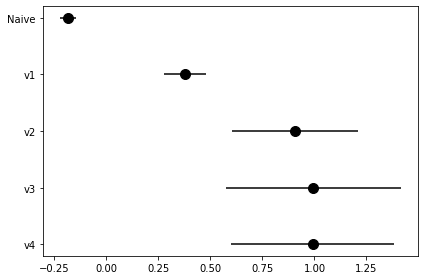

In [9]:
plt.scatter([naive_ace, cnfdr_ace, mssng_ace, slctn_ace, aipw_ace],
            [0, 1, 2, 3, 4], 
            s=100, marker='o', c='k')
plt.hlines([0, 1, 2, 3, 4], 
           [naive_ci[0], cnfdr_ci[0], mssng_ci[0], slctn_ci[0], aipw_ci[0]],
           [naive_ci[1], cnfdr_ci[1], mssng_ci[1], slctn_ci[1], aipw_ci[1]], 
           colors='k')
plt.yticks([0, 1, 2, 3, 4],
           ["Naive", "v1", "v2", "v3", "v4"])
plt.ylim([4.2, -0.2])
# plt.xlim([0.25, 1.1])
plt.tight_layout()

Therefore, we can easily see how both the estimate and the uncertainty change as we address for the various sources of bias. Additionally, we can see a benefit of the AIPW estimator in terms of efficiency. Here, the AIPW estimator was simple, other more efficient options (and additional levels of robustness) may be possible.